# Your Title Here

**Name(s)**: (your name(s) here)

**Website Link**: (your website link)


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import sklearn
import folium

import plotly.express as px

pd.options.plotting.backend = "plotly"

# from dsc80_utils import * # Feel free to uncomment and use this.

## Step 1: Introduction


In [2]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [ ]:
raw = pd.read_excel(Path("data") / "outage.xlsx")
raw.head()

,Major power outage events in the continental U.S.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,Time period: January 2000 - July 2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Regions affected: Outages reported in this dat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND


## Step 2: Data Cleaning and Exploratory Data Analysis


In [ ]:
df = (
    raw[6:]
    .reset_index(drop=True)
    .rename(columns=raw.iloc[4])
    .drop(["variables", "OBS"], axis=1)
)
df.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
1,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


In [ ]:
cleaned = df.copy()


def clean_datetime(row, col):
    if pd.notna(row[f"OUTAGE.{col}.DATE"]) and pd.notna(row[f"OUTAGE.{col}.TIME"]):
        return datetime.combine(
            row[f"OUTAGE.{col}.DATE"].date(), row[f"OUTAGE.{col}.TIME"]
        )


for col in ["START", "RESTORATION"]:
    cleaned[f"OUTAGE.{col}"] = df.apply(lambda row: clean_datetime(row, col), axis=1)
    cleaned.drop([f"OUTAGE.{col}.DATE", f"OUTAGE.{col}.TIME"], axis=1, inplace=True)
cleaned.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
0,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,severe weather,NaN,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00
1,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,intentional attack,vandalism,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2014-05-11 18:38:00,2014-05-11 18:39:00
2,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,severe weather,heavy wind,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00
3,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,severe weather,thunderstorm,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 23:00:00
4,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,severe weather,NaN,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00


In [23]:
# state_geo = requests.get(
#     "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json"
# ).json()

# state_data = cleaned.groupby("POSTAL.CODE").size()

# m = folium.Map(location=[48, -102], zoom_start=4)
# folium.Choropleth(
#     geo_data=state_geo,
#     name="choropleth",
#     data=state_data,
#     columns=[state_data.index, state_data],
#     key_on="feature.id",
#     fill_color="YlOrRd",
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name="Power Outages",
# ).add_to(m)
# m

In [ ]:
cleaned.groupby("YEAR").size().plot(
    kind="bar", title="Number of Power Outages per Year"
)

In [ ]:
cleaned.groupby("MONTH").size().plot(
    kind="bar", title="Number of Power Outages per Month"
)

In [ ]:
cleaned.assign(TIME=cleaned["OUTAGE.START"].dt.strftime("%Y-%m")).groupby(
    "TIME"
).size().plot()

In [ ]:
def plot_monthly_average(df, cols):
    return px.line(
        df.dropna(subset=cols)
        .assign(TIME=df["OUTAGE.START"].dt.strftime("%Y-%m"))
        .groupby("TIME")[cols]
        .mean()
    )


log = lambda x: np.log(x) if x else np.nan
extra_features = cleaned.assign(
    LOG_DEMAND_LOSS_MW=cleaned["DEMAND.LOSS.MW"].apply(log),
    LOG_OUTAGE_DURATION=cleaned["OUTAGE.DURATION"].apply(log),
    LOG_CUSTOMERS_AFFECTED=cleaned["CUSTOMERS.AFFECTED"].apply(log),
    START_HR=cleaned["OUTAGE.START"].dt.hour,
    START_DAY=cleaned["OUTAGE.START"].dt.day,
    START_DAYOFWEEK=cleaned["OUTAGE.START"].dt.dayofweek,
    RESTORATION_HR=cleaned["OUTAGE.RESTORATION"].dt.hour,
    RESTORATION_DAY=cleaned["OUTAGE.RESTORATION"].dt.day,
    RESTORATION_DAYOFWEEK=cleaned["OUTAGE.RESTORATION"].dt.dayofweek,
)
plot_monthly_average(
    extra_features.query("`POSTAL.CODE` == 'CA'"),
    ["LOG_DEMAND_LOSS_MW", "LOG_OUTAGE_DURATION", "LOG_CUSTOMERS_AFFECTED"],
)

<Axes: >

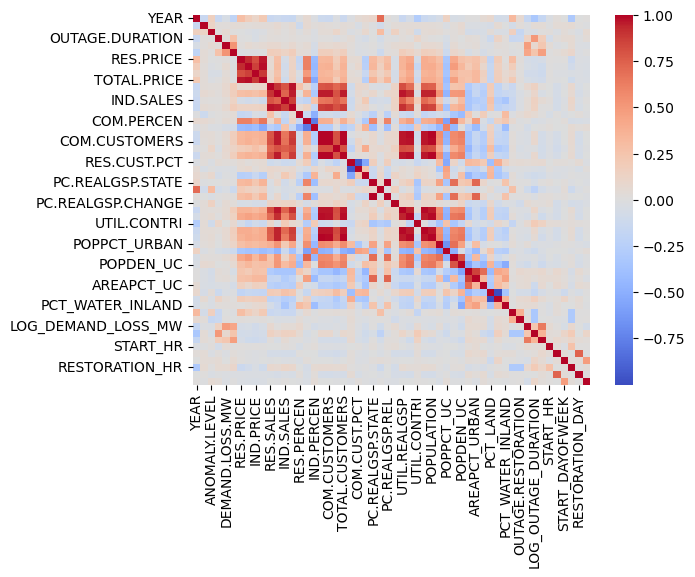

In [ ]:
cat_cols = [
    "U.S._STATE",
    "POSTAL.CODE",
    "NERC.REGION",
    "CLIMATE.REGION",
    "CLIMATE.CATEGORY",
    "CAUSE.CATEGORY",
    "CAUSE.CATEGORY.DETAIL",
    "HURRICANE.NAMES",
]
corr_matrix = extra_features.drop(cat_cols, axis=1).corr()
sns.heatmap(corr_matrix, cmap="coolwarm")

In [41]:
fig = extra_features.plot(x="LOG_DEMAND_LOSS_MW", kind="hist")
fig.add_vline(extra_features["LOG_DEMAND_LOSS_MW"].quantile(0.25), line_color="red")
fig.add_vline(extra_features["LOG_DEMAND_LOSS_MW"].quantile(0.75), line_color="red")

In [ ]:
no_zeros = extra_features.drop(
    extra_features[
        (extra_features["DEMAND.LOSS.MW"] <= 0)
        & (extra_features["CUSTOMERS.AFFECTED"] <= 0)
    ].index
)

no_zeros[["DEMAND.LOSS.MW", "CUSTOMERS.AFFECTED"]].dropna().plot(
    kind="scatter",
    x="CUSTOMERS.AFFECTED",
    y="DEMAND.LOSS.MW",
    log_x=True,
    log_y=True,
    trendline="ols",
    trendline_color_override="red",
    trendline_options=dict(log_x=True, log_y=True),
)

In [ ]:
pd.pivot_table(
    cleaned,
    index="CLIMATE.CATEGORY",
    columns="CLIMATE.REGION",
    values="CUSTOMERS.AFFECTED",
    aggfunc="mean",
).astype(int)

CLIMATE.REGION,Central,East North Central,Northeast,Northwest,South,Southeast,Southwest,West,West North Central
CLIMATE.CATEGORY,,,,,,,,,
cold,97364,120777,120320,63350,186070,142545,63196,171929,53500
normal,154125,154612,125290,42961,218077,164578,24918,186293,60106
warm,91868,101710,115443,118436,107234,268593,29596,231771,25250


## Step 3: Assessment of Missingness


In [15]:
# TODO

## Step 4: Hypothesis Testing


In [ ]:
tvd = lambda x, y: np.abs(x - y).sum() / 2
uniform = np.ones(12) / 12
month_props = cleaned.value_counts("MONTH", normalize=True).values
observed = tvd(month_props, uniform)

stats = np.array([])
for _ in range(1000):
    rand = np.random.choice(12, size=cleaned.shape[0], p=uniform)
    stat = pd.Series(rand).value_counts(normalize=True)
    stats = np.append(stats, tvd(stat, uniform))

pval = (stats >= observed).mean()
result = "Reject" if pval < 0.01 else "Fail to Reject"
print(f"p-value: {pval}\nHypothesis: {result}")

p-value: 0.0
Hypothesis: Reject


## Step 5: Framing a Prediction Problem


In [17]:
# TODO

## Step 6: Baseline Model


In [ ]:
def get_severity(row):
    if np.isnan(row["LOG_DEMAND_LOSS_MW"]):
        return np.nan
    if row["LOG_DEMAND_LOSS_MW"] > extra_features["LOG_DEMAND_LOSS_MW"].quantile(0.75):
        return "HIGH"
    if row["LOG_DEMAND_LOSS_MW"] > extra_features["LOG_DEMAND_LOSS_MW"].quantile(0.25):
        return "MEDIUM"
    return "LOW"

severity = extra_features.assign(SEVERITY=extra_features.apply(get_severity, axis=1))
severity["SEVERITY"].value_counts()

SEVERITY
MEDIUM    216
LOW       209
HIGH      208
Name: count, dtype: int64

In [203]:
severity.columns

Index(['YEAR', 'MONTH', 'U.S._STATE', 'POSTAL.CODE', 'NERC.REGION',
       'CLIMATE.REGION', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY',
       'CAUSE.CATEGORY.DETAIL', 'HURRICANE.NAMES', 'OUTAGE.DURATION',
       'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'RES.PRICE', 'COM.PRICE',
       'IND.PRICE', 'TOTAL.PRICE', 'RES.SALES', 'COM.SALES', 'IND.SALES',
       'TOTAL.SALES', 'RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN',
       'RES.CUSTOMERS', 'COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS',
       'RES.CUST.PCT', 'COM.CUST.PCT', 'IND.CUST.PCT', 'PC.REALGSP.STATE',
       'PC.REALGSP.USA', 'PC.REALGSP.REL', 'PC.REALGSP.CHANGE', 'UTIL.REALGSP',
       'TOTAL.REALGSP', 'UTIL.CONTRI', 'PI.UTIL.OFUSA', 'POPULATION',
       'POPPCT_URBAN', 'POPPCT_UC', 'POPDEN_URBAN', 'POPDEN_UC',
       'POPDEN_RURAL', 'AREAPCT_URBAN', 'AREAPCT_UC', 'PCT_LAND',
       'PCT_WATER_TOT', 'PCT_WATER_INLAND', 'OUTAGE.START',
       'OUTAGE.RESTORATION', 'LOG_DEMAND_LOSS_MW', 'LOG_OUTAGE_DURATION',
    

In [214]:
severity.plot(x="DEMAND.LOSS.MW", kind="hist", color="SEVERITY")

## Step 7: Final Model


In [19]:
# TODO

## Step 8: Fairness Analysis


In [20]:
# TODO